
=== AEGIS ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
AEGIS: SVR MSE=0.00905  |  EAZY MSE=0.02246 (n_eazy=329)

=== COSMOS ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
COSMOS: SVR MSE=0.00258  |  EAZY MSE=0.00345 (n_eazy=126)

=== GOODS-S ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
GOODS-S: SVR MSE=0.12159  |  EAZY MSE=0.12040 (n_eazy=384)

=== GOODS-N ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
GOODS-N: SVR MSE=0.14690  |  EAZY MSE=0.11567 (n_eazy=551)

=== UDS ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
UDS: SVR MSE=0.04314  |  EAZY MSE=0.15607 (n_eazy=53)


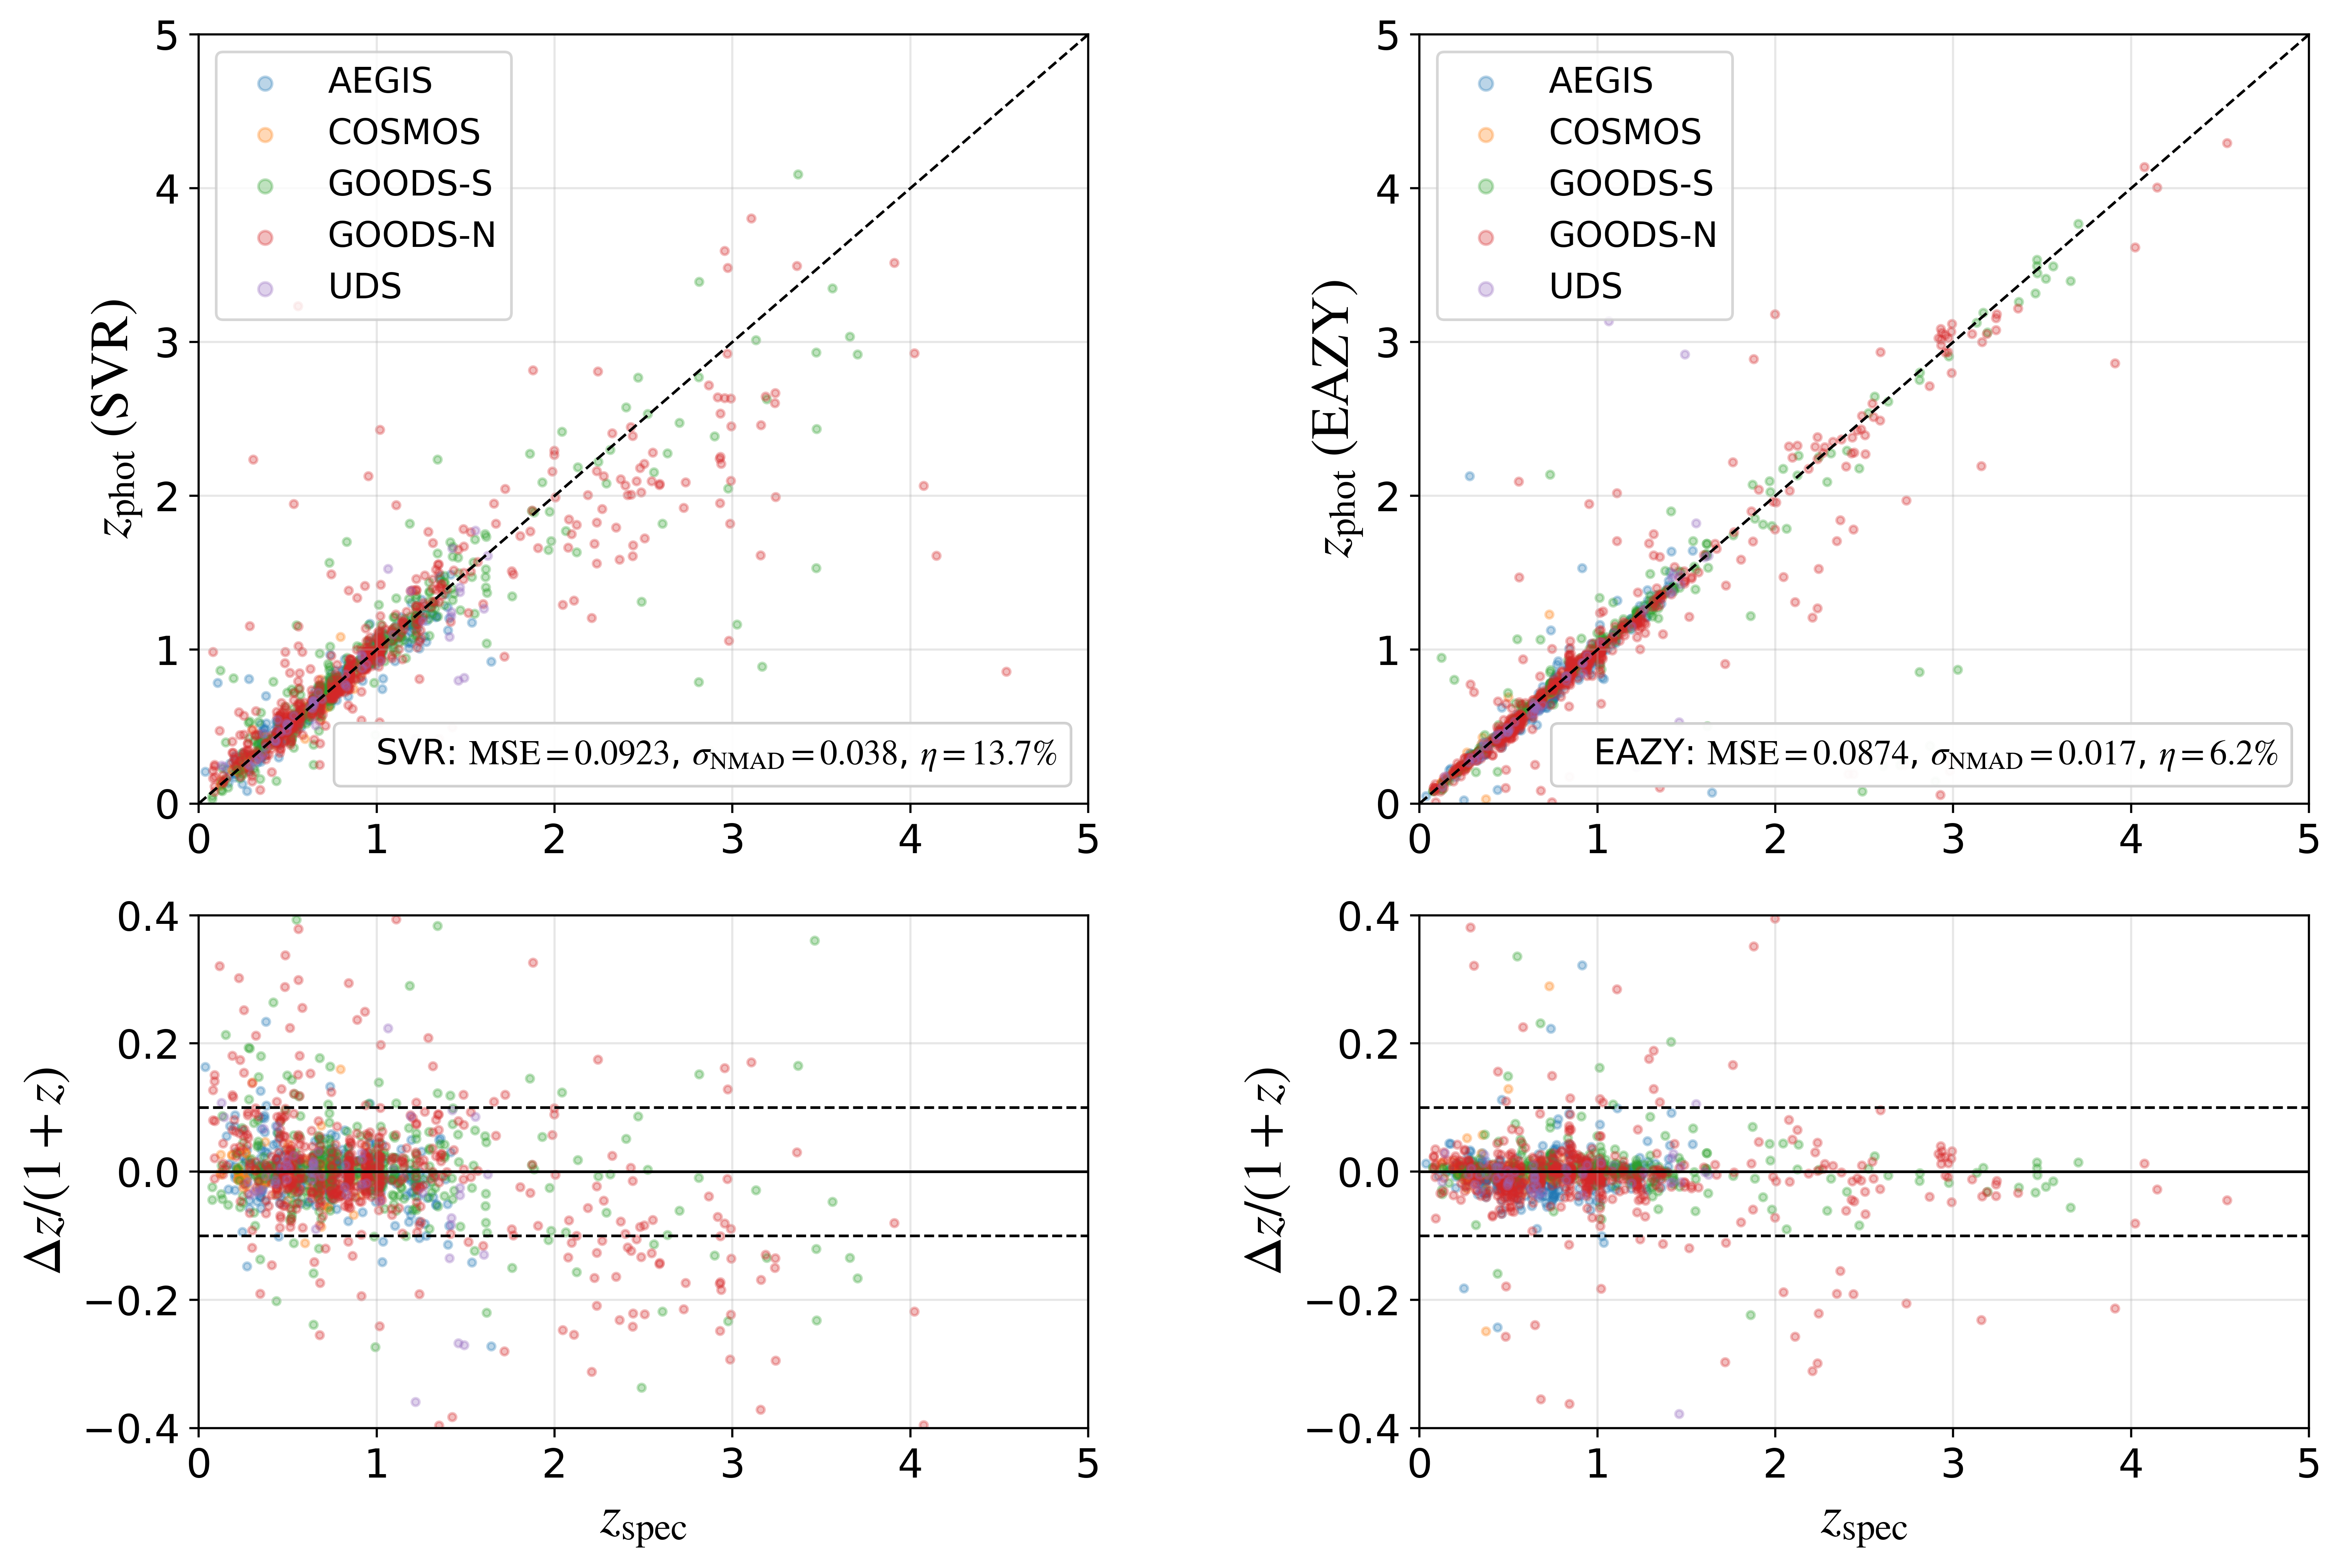


Per-field summary:
  field  n_test  mse_svr  mse_eazy  n_eazy
  AEGIS     329  0.00905   0.02246     329
 COSMOS     126  0.00258   0.00345     126
GOODS-N     551  0.14690   0.11567     551
GOODS-S     384  0.12159   0.12040     384
    UDS      53  0.04314   0.15607      53

Global (all fields, test sets combined):
SVR  -> MSE(z)=0.09232, NMAD=0.0375, η=13.72%
EAZY -> MSE(z)=0.08736, NMAD=0.0175, η=6.17%


In [8]:
import os
import itertools
import numpy as np
import pandas as pd
from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.svm import SVR
from scipy.stats import randint, uniform, reciprocal  # reciprocal = log-uniform

# -------------------------
# Paths (EDIT THESE)
# -------------------------
BASE = "/Users/fengbocheng/Projects/Photometric-Redshifts"

FIELDS = {
    "AEGIS": {
        "cat":  f"{BASE}/aegis_3dhst.v4.1.cats/Catalog/aegis_3dhst.v4.1.cat",
        "zout": f"{BASE}/aegis_3dhst.v4.1.cats/Eazy/aegis_3dhst.v4.1.zout",
        "bands": [
            "U","G","F606W","R","I","F814W","Z",
            "F125W","J1","J2","J3","J","F140W","H1","H2","H","K","Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "COSMOS": {
        "cat":  f"{BASE}/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat",
        "zout": f"{BASE}/cosmos_3dhst.v4.1.cats/Eazy/cosmos_3dhst.v4.1.zout",
        "bands": [
            "U","B","G","V","F606W","R","Rp","I","Ip","F814W","Z","Zp",
            "UVISTA_Y","F125W","J1","J2","J3","J","UVISTA_J","F140W",
            "H1","H2","H","UVISTA_H","K","Ks","UVISTA_Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "GOODS-S": {
        "cat":  f"{BASE}/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat",
        "zout": f"{BASE}/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout",
        "bands": [
            "U38","U","F435W","B","V","F606W","R","Rc","F775W","I","F814W","F850LP",
            "F125W","J","F140W","H","Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "GOODS-N": {
        "cat":  f"{BASE}/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat",
        "zout": f"{BASE}/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout",
        "bands": [
            "U","F435W","B","G","V","F606W","R","Rs","I","F775W","Z","F850LP",
            "F125W","J","F140W","H","Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "UDS": {
        "cat":  f"{BASE}/uds_3dhst.v4.2.cats/Catalog/uds_3dhst.v4.2.cat",
        "zout": f"{BASE}/uds_3dhst.v4.2.cats/Eazy/uds_3dhst.v4.2.zout",
        "bands": [
            "u","B","V","F606W","R","i","F814W","z",
            "F125W","J","F140W","H","K",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
}

# -------------------------
# Config
# -------------------------
TARGET_COL        = "z_spec"
MAG_ZP            = 25.0
FLUX_FLOOR        = 1e-6
INCLUDE_COLORS    = True
N_BINS_STRAT      = 8   # for stratified split
PLOT_BINS         = 12  # for metric-vs-z plots
OUTLIER_THR       = 0.10  # |Δz|/(1+z) threshold

# Colors for plotting
PALETTE = {"AEGIS":"C0", "COSMOS":"C1", "GOODS-S":"C2", "GOODS-N":"C3", "UDS":"C4"}

# -------------------------
# Helpers
# -------------------------
def flux_to_mag(flux, zp=MAG_ZP):
    f = np.asarray(flux)
    f = np.where(np.isfinite(f) & (f > 0), f, np.nan)
    f = np.clip(f, FLUX_FLOOR, np.inf)
    return zp - 2.5*np.log10(f)

def build_features_in_bulk(tab: pd.DataFrame, bands: list, include_colors=True) -> pd.DataFrame:
    new_cols = {}
    # magnitudes
    for b in bands:
        fcol = f"f_{b}"
        if fcol in tab.columns:
            new_cols[f"mag_{b}"] = flux_to_mag(tab[fcol].to_numpy())
    # colors
    if include_colors:
        for a, b in itertools.combinations(bands, 2):
            ca, cb = f"mag_{a}", f"mag_{b}"
            if ca in new_cols and cb in new_cols:
                new_cols[f"color_{a}_{b}"] = new_cols[ca] - new_cols[cb]
            elif (ca in tab.columns) and (cb in tab.columns):
                new_cols[f"color_{a}_{b}"] = tab[ca] - tab[cb]
    # S/N
    for b in bands:
        f, e = f"f_{b}", f"e_{b}"
        if (f in tab.columns) and (e in tab.columns):
            earr = tab[e].to_numpy(); farr = tab[f].to_numpy()
            snr = np.where((earr > 0) & np.isfinite(earr) & np.isfinite(farr), farr / earr, np.nan)
            new_cols[f"snr_{b}"] = snr
    if new_cols:
        feat_df = pd.DataFrame(new_cols, index=tab.index)
        return pd.concat([tab, feat_df], axis=1).copy()
    return tab.copy()

def stratified_train_test_indices(y: np.ndarray, test_size=0.3, n_bins=10, seed=42):
    idx = np.where(np.isfinite(y))[0]
    yv = y[idx]
    q = np.quantile(yv, np.linspace(0, 1, n_bins+1))
    q = np.unique(q)
    if len(q) < 3:
        q = np.quantile(yv, np.linspace(0, 1, 6))
    bins = np.digitize(yv, q[1:-1], right=True)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    tr_rel, te_rel = next(sss.split(np.zeros_like(yv), bins))
    return idx[tr_rel], idx[te_rel]

def build_pipeline(feature_cols):
    """
    Same preprocessing as before (median impute + StandardScaler),
    but using an SVR regressor with RBF kernel inside the pipeline.
    """
    preproc = ColumnTransformer(
        transformers=[("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ]), feature_cols)],
        remainder="drop",
    )
    svr = SVR(kernel="rbf", cache_size=1000)
    pipe = Pipeline(steps=[("pre", preproc), ("svr", svr)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)
    return model

def tuner():
    """
    Hyperparameter space for SVR (log-uniform where it matters).
    We keep the same RandomizedSearchCV logic & scoring as your RF version.
    """
    return {
        "regressor__svr__C":       reciprocal(1e-1, 1e3),   # ~[0.1, 1000], log-uniform
        "regressor__svr__gamma":   reciprocal(1e-4, 1e0),   # ~[1e-4, 1],   log-uniform
        "regressor__svr__epsilon": reciprocal(1e-3, 1e-1),  # ~[1e-3, 0.1], log-uniform
    }

def nmad(delta):
    d = delta[np.isfinite(delta)]
    if d.size == 0:
        return np.nan
    med = np.median(d)
    return 1.4826 * np.median(np.abs(d - med))

def outlier_fraction(delta, thr=OUTLIER_THR):
    d = delta[np.isfinite(delta)]
    if d.size == 0:
        return np.nan
    return np.mean(np.abs(d) > thr)

def binned_metrics(zspec, zpred, nbins=12, zmin=None, zmax=None):
    zspec = np.asarray(zspec)
    zpred = np.asarray(zpred)
    mask = np.isfinite(zspec) & np.isfinite(zpred)
    zspec = zspec[mask]; zpred = zpred[mask]
    if zspec.size == 0:
        edges = np.linspace(0, 1, nbins+1)
        centers = 0.5*(edges[:-1]+edges[1:])
        arr = np.full(nbins, np.nan)
        return centers, arr, arr, arr

    if zmin is None: zmin = np.nanmin(zspec)
    if zmax is None: zmax = np.nanmax(zspec)
    edges = np.linspace(zmin, zmax, nbins+1)
    centers = 0.5*(edges[:-1]+edges[1:])
    mse_b, nmad_b, out_b = [], [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        m = (zspec >= lo) & (zspec < hi)
        if not np.any(m):
            mse_b.append(np.nan); nmad_b.append(np.nan); out_b.append(np.nan)
            continue
        dz   = zpred[m] - zspec[m]
        dzn  = dz / (1.0 + zspec[m])
        mse_b.append(mean_squared_error(zspec[m], zpred[m]))
        nmad_b.append(nmad(dzn))
        out_b.append(outlier_fraction(dzn, thr=OUTLIER_THR))
    return centers, np.array(mse_b), np.array(nmad_b), np.array(out_b)

def nmad_from_resid(d):
    d = d[np.isfinite(d)]
    if d.size == 0:
        return np.nan
    med = np.median(d)
    return 1.4826 * np.median(np.abs(d - med))

def nmad_scorer_func(y_true, y_pred):
    dzn = (y_pred - y_true) / (1.0 + y_true)
    val = nmad_from_resid(dzn)
    return -val if np.isfinite(val) else -1e9

NMAD_SCORER = make_scorer(nmad_scorer_func, greater_is_better=True)

# -------------------------
# Main loop over fields
# -------------------------
all_points_svr   = []  # (field, z_spec_test, z_pred_svr)
all_points_eazy  = []  # (field, z_spec_test_for_ez, z_eazy_test)
metrics = []
all_svr_zspec, all_svr_pred = [], []
all_ez_zspec,  all_ez_pred  = [], []

for field_name, cfg in FIELDS.items():
    print(f"\n=== {field_name} ===")

    tab  = Table.read(cfg["cat"],  format="ascii").to_pandas()
    zout = Table.read(cfg["zout"], format="ascii").to_pandas()[["id", "z_peak"]]

    if "id" not in tab.columns:
        raise ValueError(f"{field_name}: photometric catalog missing 'id'.")
    tab = tab.merge(zout, on="id", how="left")

    use_col = cfg.get("use_col", "use_phot")
    if use_col in tab.columns:
        tab = tab[tab[use_col] == 1].copy()

    if TARGET_COL not in tab.columns:
        raise ValueError(f"{field_name}: missing {TARGET_COL}.")
    tab = tab[np.isfinite(tab[TARGET_COL]) & (tab[TARGET_COL] > 0)].copy()

    for b in cfg["bands"]:
        e = f"e_{b}"
        if e in tab.columns:
            bad = (~np.isfinite(tab[e])) | (tab[e] <= 0) | (tab[e] < -90)
            tab.loc[bad, e] = np.nan

    tab = build_features_in_bulk(tab, cfg["bands"], include_colors=INCLUDE_COLORS)
    feature_cols = [c for c in tab.columns if c.startswith(("mag_", "color_", "snr_"))]

    y_all = tab[TARGET_COL].to_numpy()
    tr_idx, te_idx = stratified_train_test_indices(y_all, test_size=0.3, n_bins=N_BINS_STRAT, seed=42)
    X_train = tab.iloc[tr_idx][feature_cols]; y_train = y_all[tr_idx]
    X_test  = tab.iloc[te_idx][feature_cols]; y_test  = y_all[te_idx]

    model = build_pipeline(feature_cols)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=tuner(),
        n_iter=20, cv=3,
        scoring="neg_mean_squared_error",  # keep same logic as your RF version
        random_state=42, verbose=1,
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    z_svr_test = best_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, z_svr_test)

    z_eazy_test = tab.iloc[te_idx]["z_peak"].to_numpy()
    mask_ez = np.isfinite(z_eazy_test)
    mse_ez = mean_squared_error(y_test[mask_ez], z_eazy_test[mask_ez]) if np.any(mask_ez) else np.nan

    print(f"{field_name}: SVR MSE={mse_svr:.5f}  |  EAZY MSE={mse_ez:.5f} (n_eazy={mask_ez.sum()})")

    all_points_svr.append((field_name, y_test, z_svr_test))
    all_svr_zspec.append(y_test); all_svr_pred.append(z_svr_test)

    all_points_eazy.append((field_name, y_test[mask_ez], z_eazy_test[mask_ez]))
    if np.any(mask_ez):
        all_ez_zspec.append(y_test[mask_ez]); all_ez_pred.append(z_eazy_test[mask_ez])

    metrics.append({
        "field": field_name,
        "n_test": len(y_test),
        "mse_svr": mse_svr,
        "mse_eazy": mse_ez,
        "n_eazy": int(mask_ez.sum())
    })

# -------------------------
# Global metrics (for legend annotations)
# -------------------------
all_svr_zspec = np.concatenate(all_svr_zspec) if len(all_svr_zspec) else np.array([])
all_svr_pred  = np.concatenate(all_svr_pred)  if len(all_svr_pred)  else np.array([])
svr_dz_norm   = (all_svr_pred - all_svr_zspec) / (1.0 + all_svr_zspec)
SVR_MSE   = mean_squared_error(all_svr_zspec, all_svr_pred) if all_svr_zspec.size else np.nan
SVR_NMAD  = nmad(svr_dz_norm)
SVR_ETA   = outlier_fraction(svr_dz_norm, thr=OUTLIER_THR)

if len(all_ez_zspec):
    all_ez_zspec = np.concatenate(all_ez_zspec)
    all_ez_pred  = np.concatenate(all_ez_pred)
    ez_dz_norm   = (all_ez_pred - all_ez_zspec) / (1.0 + all_ez_zspec)
    EZ_MSE  = mean_squared_error(all_ez_zspec, all_ez_pred)
    EZ_NMAD = nmad(ez_dz_norm)
    EZ_ETA  = outlier_fraction(ez_dz_norm, thr=OUTLIER_THR)
else:
    all_ez_zspec = np.array([]); all_ez_pred = np.array([])
    ez_dz_norm   = np.array([])
    EZ_MSE = EZ_NMAD = EZ_ETA = np.nan

# -------------------------
# FIGURE 1: Top (z_phot vs z_spec), Bottom (Δz/(1+z) vs z_spec), SVR vs EAZY
# -------------------------
def apply_style(
    family="DejaVu Sans", math="stix", use_tex=False,
    base=15, label=20, title=18, tick=15, leg=13, leg_title=14
):
    plt.rcParams.update({
        "font.family": family,
        "font.size": base,
        "axes.labelsize": label,
        "axes.titlesize": title,
        "xtick.labelsize": tick,
        "ytick.labelsize": tick,
        "legend.fontsize": leg,
        "legend.title_fontsize": leg_title,
        "text.usetex": use_tex,
        "mathtext.fontset": math,
    })

apply_style() 

zmin, zmax = 0.0, 5.0
res_ylim   = (-0.4, 0.4)

fig = plt.figure(figsize=(12, 8), dpi=500, constrained_layout=True)
gs  = gridspec.GridSpec(
    nrows=2, ncols=2, figure=fig,
    height_ratios=[3, 2], wspace=0.12, hspace=0.05
)

# -- SVR: top scatter and bottom residual (share x)
ax_svr_top = fig.add_subplot(gs[0, 0])
ax_svr_bot = fig.add_subplot(gs[1, 0], sharex=ax_svr_top)

# Top: identity line first, then points
ax_svr_top.plot([zmin, zmax], [zmin, zmax], color='k', ls='--', lw=1)
for field, z_spec_vec, z_svr_vec in all_points_svr:
    ax_svr_top.scatter(z_spec_vec, z_svr_vec, s=8, alpha=0.30, color=PALETTE[field], label=field)

ax_svr_top.set_xlim(zmin, zmax)
ax_svr_top.set_ylim(zmin, zmax)
ax_svr_top.grid(alpha=0.3)
ax_svr_top.set_ylabel(r"$z_{\mathrm{phot}}\;(\mathrm{SVR})$")

# Legends: fields (UL) + metrics (LR)
handles, labels = ax_svr_top.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
leg_fields = ax_svr_top.legend(uniq.values(), uniq.keys(),
                               markerscale=1.8, frameon=True, loc="upper left")
ax_svr_top.add_artist(leg_fields)

svr_label = (rf"SVR: $\mathrm{{MSE}}={SVR_MSE:.4f}$, "
             rf"$\sigma_{{\mathrm{{NMAD}}}}={SVR_NMAD:.3f}$, "
             rf"$\eta={100*SVR_ETA:.1f}\%$")
leg_metrics = ax_svr_top.legend(
    [plt.Line2D([0],[0], ls='', color='k')],
    [svr_label], loc="lower right", frameon=True, handlelength=0
)
ax_svr_top.add_artist(leg_metrics)

# Bottom: normalized residuals
for field, z_spec_vec, z_svr_vec in all_points_svr:
    dzn = (z_svr_vec - z_spec_vec) / (1.0 + z_spec_vec)
    ax_svr_bot.scatter(z_spec_vec, dzn, s=8, alpha=0.3, color=PALETTE[field])

ax_svr_bot.axhline(0.0, color='k', lw=1, ls='-')
ax_svr_bot.axhline(+OUTLIER_THR, color='k', lw=1, ls='--')
ax_svr_bot.axhline(-OUTLIER_THR, color='k', lw=1, ls='--')
ax_svr_bot.set_ylim(res_ylim)
ax_svr_bot.grid(alpha=0.3)
ax_svr_bot.set_xlabel(r"$z_{\mathrm{spec}}$")
ax_svr_bot.set_ylabel(r"$\Delta z/(1+z)$")

# -- EAZY: top scatter and bottom residual (share x & y with SVR top)
ax_ez_top = fig.add_subplot(gs[0, 1], sharex=ax_svr_top, sharey=ax_svr_top)
ax_ez_bot = fig.add_subplot(gs[1, 1], sharex=ax_svr_top)

ax_ez_top.plot([zmin, zmax], [zmin, zmax], color='k', ls='--', lw=1)
for field, z_spec_vec, z_ez_vec in all_points_eazy:
    ax_ez_top.scatter(z_spec_vec, z_ez_vec, s=8, alpha=0.30, color=PALETTE[field], label=field)

ax_ez_top.set_xlim(zmin, zmax)
ax_ez_top.set_ylim(zmin, zmax)
ax_ez_top.grid(alpha=0.3)
ax_ez_top.set_ylabel(r"$z_{\mathrm{phot}}\;(\mathrm{EAZY})$")

handles2, labels2 = ax_ez_top.get_legend_handles_labels()
uniq2 = dict(zip(labels2, handles2))
leg_fields2 = ax_ez_top.legend(uniq2.values(), uniq2.keys(),
                               markerscale=1.8, frameon=True, loc="upper left")
ax_ez_top.add_artist(leg_fields2)

ez_label = (rf"EAZY: $\mathrm{{MSE}}={EZ_MSE:.4f}$, "
            rf"$\sigma_{{\mathrm{{NMAD}}}}={EZ_NMAD:.3f}$, "
            rf"$\eta={100*EZ_ETA:.1f}\%$")
leg_metrics2 = ax_ez_top.legend(
    [plt.Line2D([0],[0], ls='', color='k')],
    [ez_label], loc="lower right", frameon=True, handlelength=0, 
)
ax_ez_top.add_artist(leg_metrics2)

for field, z_spec_vec, z_ez_vec in all_points_eazy:
    dzn = (z_ez_vec - z_spec_vec) / (1.0 + z_spec_vec)
    ax_ez_bot.scatter(z_spec_vec, dzn, s=8, alpha=0.3, color=PALETTE[field])

ax_ez_bot.axhline(0.0, color='k', lw=1, ls='-')
ax_ez_bot.axhline(+OUTLIER_THR, color='k', lw=1, ls='--')
ax_ez_bot.axhline(-OUTLIER_THR, color='k', lw=1, ls='--')
ax_ez_bot.set_ylim(res_ylim)
ax_ez_bot.grid(alpha=0.3)
ax_ez_bot.set_xlabel(r"$z_{\mathrm{spec}}$")
ax_ez_bot.set_ylabel(r"$\Delta z/(1+z)$")

plt.show()

# -------------------------
# Print per-field table
# -------------------------
met_df = pd.DataFrame(metrics).sort_values("field")
print("\nPer-field summary:")
print(met_df.to_string(index=False, float_format=lambda x: f"{x:.5f}"))
print("\nGlobal (all fields, test sets combined):")
print(f"SVR  -> MSE(z)={SVR_MSE:.5f}, NMAD={SVR_NMAD:.4f}, η={100*SVR_ETA:.2f}%")
print(f"EAZY -> MSE(z)={EZ_MSE:.5f}, NMAD={EZ_NMAD:.4f}, η={100*EZ_ETA:.2f}%")